In [71]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-03-28 16:49:10,498 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:83:b1:6a:38:3C
2023-03-28 16:49:14,341 | INFO     |: Connected to C0:83:b1:6a:38:3C


In [73]:
def get_data_cb(uuid, byte_array):
    global tof_list, pwm_list
    if byte_array is not None:
        s = byte_array.decode("utf-8")
        s = s.split("|")  # split each reading
        
        if s[0] == 'T':
            # TOF
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                tof  = int(data[1])
                if tof > 0:
                    tof_time_list.append(time)
                    tof_data_list.append(tof)
        
        elif s[0] == 'P':
            # PWM
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                pwm  = int(data[1])
                if pwm > 0:
                    pwm_time_list.append(time)
                    pwm_data_list.append(pwm)
        
        elif s[0] == 'K':
            # PWM
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                kf  = int(data[1])
                if kf > 0:
                    kf_time_list.append(time)
                    kf_data_list.append(kf)

In [74]:
ble.start_notify(ble.uuid['RX_STRING'], get_data_cb)

In [75]:
tof_data_list = []
pwm_data_list = []
tof_time_list = []
pwm_time_list = []
kf_data_list = []
kf_time_list = []


In [76]:
# start
ble.send_command(CMD.SEND_TWO_INTS, "")

In [77]:
# stop
ble.send_command(CMD.SEND_THREE_FLOATS, "")

In [78]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [79]:
tof_time_list = [x - tof_time_list[0] for x in tof_time_list]
pwm_time_list = [x - pwm_time_list[0] for x in pwm_time_list]
kf_time_list  = [x - kf_time_list[0]  for x in kf_time_list ]

if tof_time_list[-1] > 1000:
    tof_time_list = np.array(tof_time_list)/1000
    pwm_time_list = np.array(pwm_time_list)/1000

In [80]:
print(tof_data_list)
print(tof_time_list)
print(pwm_data_list)
print(pwm_time_list)
print(kf_data_list)
print(kf_time_list)

[1864, 1895, 1884, 1872, 1837, 1785, 1713, 1653, 1559, 1487, 1358, 1268, 1140, 1016, 868]
[0.    0.096 0.206 0.299 0.4   0.497 0.606 0.699 0.802 0.897 1.003 1.099
 1.205 1.3   1.409]
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[0.    0.104 0.214 0.302 0.406 0.506 0.609 0.702 0.806 0.904 1.013 1.106
 1.21  1.308]
[1956, 1896, 1849, 1811, 1767, 1713, 1645, 1580, 1496, 1418, 1309, 1211, 1095, 974]
[0, 104, 212, 303, 405, 503, 608, 704, 808, 902, 1013, 1104, 1207, 1309]


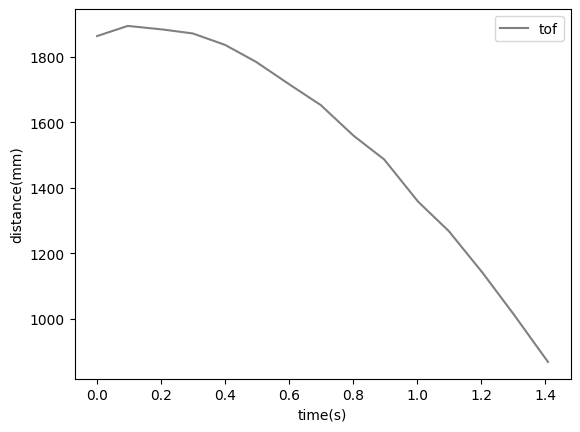

In [81]:
plt.plot(tof_time_list, tof_data_list, color='gray', label='tof')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('distance(mm)')
plt.show()

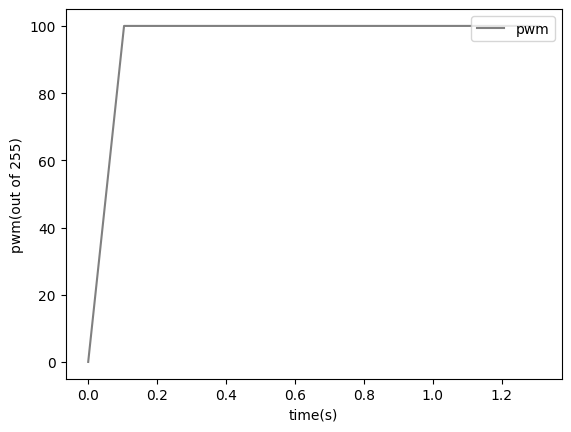

In [82]:
if pwm_data_list[0] != 0:
    pwm_data_list[0] = 0

plt.plot(pwm_time_list, pwm_data_list, color='gray', label='pwm')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('pwm(out of 255)')
plt.show()

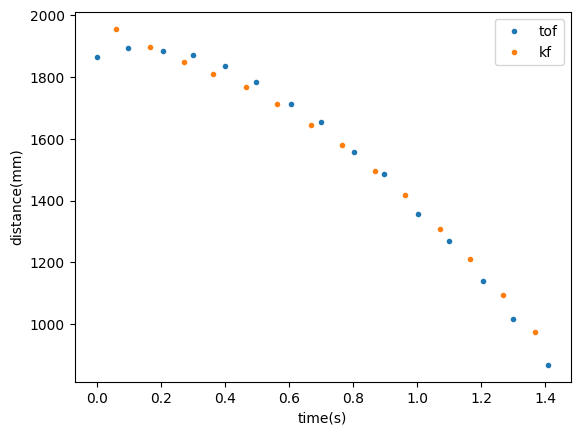

In [84]:
plt.plot(tof_time_list, tof_data_list, '.', label='tof')
plt.plot((np.array(kf_time_list)+60)/1000, kf_data_list, '.', label='kf')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('distance(mm)')
plt.show()

In [ ]:
velocity_list = -1 * np.diff(tof_data_list)/np.diff(tof_time_list)
plt.plot(tof_time_list[1:], velocity_list, color='gray', label='velocity')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('velocity(mm/s)')
plt.show()

In [ ]:
max_vel = max(velocity_list)
rise_val = max_vel * 0.9
rise_time = tof_time_list[ np.where(velocity_list > rise_val)[0][0] + 1]
drag = 1/max_vel

print("90% rise time =", rise_time, "s")
print("Max velocity = {v:.2f}".format(v=max_vel), "mm/s")
print("Drag = {d:.6f}".format(d=drag))